In [1]:
import PIL
from PIL import Image, ImageDraw
import colorsys
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches

%load_ext autoreload
%autoreload 2
from Modules import shapes
from Modules import colors
from Modules import image_maker

In [2]:
#we will focus on drawing the images first. 

"""
Each image will have at least one of and up to all of the following: 

1. A triangle
2. A circle
3. A square
"""

'\nEach image will have at least one of and up to all of the following: \n\n1. A triangle\n2. A circle\n3. A square\n'

In [3]:
color_picker = colors.ColorPicker(colors.KNOWN_COLORS, colors.default_hls_settings)

In [4]:
colors_lst = color_picker(4)

In [5]:
#print(colors)

In [6]:
#colors.pop()

In [7]:
#print(colors)

In [8]:
"""
This is how to generate an image with a background color
"""
canvas_size = (224, 224)
canvas_color = (228, 150, 150)

canvas = Image.new(mode='RGB',
                   size=canvas_size,
                   color=colors_lst.pop(),
                  )

In [9]:
#canvas.show()

In [10]:
draw = ImageDraw.Draw(canvas)

In [11]:
"""
Here we will draw a triangle
"""
# coordinates = [
#     (12, 72),
#     (40, 37),
#     (100, 96)
# ]
# color = (132, 25, 68)
# draw.polygon(xy=coordinates,
#              fill=color)

triangle = shapes.Triangle()(image_shape=canvas_size, color=colors_lst.pop())
draw.polygon(xy=triangle.parameterization,
             fill=triangle.color)

In [12]:
#canvas.show()

In [13]:
"""
Here we draw a circle

draw.ellipse()

PARAMETERS:
xy – Two points to define the bounding box. Sequence of either [(x0, y0), (x1, y1)] or [x0, y0, x1, y1], where x1 >= x0 and y1 >= y0.

outline – Color to use for the outline.

fill – Color to use for the fill.

width –

The line width, in pixels.
"""


# def generate_bounding_box(starting_point, size):
#     """Given the x0, y0, generate the x1, y1 where x1 > x0 and y1 > y0"""
#     other_point = tuple(point + size for point in starting_point)
#     parameterization = [starting_point, other_point]
#     return parameterization

# starting_point = (200, 200)
# color = (177, 200, 37)
# draw.ellipse(xy=generate_bounding_box(starting_point, 50),
#             fill=color)

specifications = {
    'min_size': 25,
    'max_size': 66
}

circle = shapes.Circle(specifications=specifications)(color=colors_lst.pop(), image_shape=canvas_size)
draw.ellipse(xy=circle.parameterization,
             fill=circle.color)

In [14]:
#canvas.show()

In [15]:
"""
Now lets make the square
"""

specifications = {
    'min_size': 30,
    'max_size': 82
}
# starting_point = (170, 100)
fillcolor = (69, 69, 69)
# draw.rectangle(xy=generate_bounding_box(starting_point, 75),
#                fill=fillcolor)

square = shapes.Square(specifications=specifications)(color=colors_lst.pop(),image_shape=canvas_size)
draw.rectangle(xy=square.parameterization,
               fill=square.color)

## Making the images programmatically

In [16]:
color_picker = colors.ColorPicker(colors.KNOWN_COLORS, colors.default_hls_settings)

In [17]:
img_generator = image_maker.ImageMaker(image_shape=(224, 224),
                                       color_picker=color_picker,
                                       number_of_colors=4,
                                       shapes = [
                                           shapes.Triangle(),
                                           shapes.Circle(specifications={
                                               'min_size': 30,
                                               'max_size': 82
                                           }),
                                           shapes.Square(specifications={
                                               'min_size': 25,
                                               'max_size': 66
                                           })
                                       ]
)

In [18]:
image_instance = img_generator()

In [19]:
image_instance

{'image_shape': (224, 224),
 'background_color': (206, 206, 136),
 'shapes': {'Triangle': Triangle(parameterization=[(42, 99), (123, 120), (85, 186)], color=(171, 136, 206)),
  'Square': Square(parameterization=[(10, 87), (70, 147)], color=(136, 136, 206))}}

In [20]:
#image_maker.construct_image(image_instance)

In [21]:
image = image_maker.construct_image(image_instance)

In [22]:
#image.show()

In [23]:
image_as_array = np.array(image)

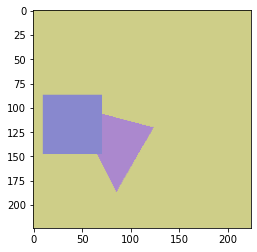

In [24]:
plt.imshow(image_as_array)

In [25]:
def really_slow_mask_maker(image_array, color):
    """ugh"""
    rows, columns, channels = image_array.shape
    mask = np.zeros((rows, columns), float)
    for i in range(rows):
        for j in range(columns):
            r = image_array[i, j, 0]
            g = image_array[i, j, 1]
            b = image_array[i, j, 2]
            if (r, g, b) == color:
                mask[i, j] = 1
    return mask

def create_all_masks(image_array, image_instance):
    """creates a mask for all of the shapes present in the image"""
    masks_dict = dict()
    for shapetype, shape_instance in image_instance['shapes'].items():
        color = shape_instance.color
        mask = really_slow_mask_maker(image_array, color)
        masks_dict[shapetype] = mask
    return masks_dict

In [26]:
mask_dict = create_all_masks(image_as_array, image_instance)

In [27]:
def extract_bboxes(mask):
    """Compute bounding boxes from masks.
    mask: [height, width, num_instances]. Mask pixels are either 1 or 0.

    Returns: bbox array [num_instances, (y1, x1, y2, x2)].
    """
    comp_mask = np.expand_dims(mask, axis=2) #expands on the last dim for this function
    boxes = np.zeros([comp_mask.shape[-1], 4], dtype=np.int32)
    for i in range(comp_mask.shape[-1]):
        m = comp_mask[:, :, i]
        # Bounding box.
        horizontal_indicies = np.where(np.any(m, axis=0))[0]
        vertical_indicies = np.where(np.any(m, axis=1))[0]
        if horizontal_indicies.shape[0]:
            x1, x2 = horizontal_indicies[[0, -1]]
            y1, y2 = vertical_indicies[[0, -1]]
            # x2 and y2 should not be part of the box. Increment by 1.
            x2 += 1
            y2 += 1
        else:
            # No mask for this instance. Might happen due to
            # resizing or cropping. Set bbox to zeros
            x1, x2, y1, y2 = 0, 0, 0, 0
        boxes[i] = np.array([y1, x1, y2, x2])
    return boxes.astype(np.int32)

def get_bbox_dict(masks_dict: dict):
    """It was the best of times, it was the worst of times"""
    bbox_dict = dict()
    for shapetype, mask in masks_dict.items():
        bbox_dict[shapetype] = extract_bboxes(mask)[0]
    return bbox_dict

def get_height_and_width(y1, x1, y2, x2):
    """why does this have to be so painful"""
    height = abs(y2 - y1)
    width = abs(x2 - x1)
    return height, width

def make_patch(bbox):
    y1, x1, y2, x2 = bbox
    height, width = get_height_and_width(y1, x1, y2, x2)
    rect = patches.Rectangle((x1, y1),
                             width=width,
                             height=height,
                             edgecolor='r',
                             facecolor='none')
    return rect
def make_patches(bbox_dict):
    """makes all patches for all of the shapes"""
    return [make_patch(bbox) for bbox in bbox_dict.values()]

In [28]:
def make_full_image_analysis(image_array, image_instance):
    """makes everything we need to make the full plot of all the masksk and ground truth boxes"""
    mask_dict = create_all_masks(image_array, image_instance)
    bbox_dict = get_bbox_dict(mask_dict)
    number_of_axes = 2 + len(mask_dict)
    bbox_patches = make_patches(bbox_dict)
    fig, axs = plt.subplots(1, number_of_axes, dpi=250)
    axs[0].imshow(image_array)
    axs[0].axis('off')
    axs[1].imshow(image_array)
    axs[1].axis('off')
    for patch in bbox_patches:
        axs[1].add_patch(patch)
    i = 2
    for mask in mask_dict.values():
        axes = axs[i]
        axes.imshow(mask, cmap='gray')
        axes.axis('off')
        i+=1
    plt.show(block=False)
    plt.pause(2)
    plt.close()

In [29]:
bbox_dict = get_bbox_dict(mask_dict)
bbox_patches = make_patches(bbox_dict)

In [30]:
bbox_patches

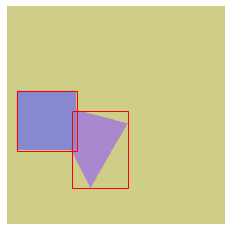

In [31]:
fig, ax = plt.subplots()
ax.imshow(image)
ax.axis('off')
for patch in bbox_patches:
    ax.add_patch(patch)

In [32]:
image_instance

{'image_shape': (224, 224),
 'background_color': (206, 206, 136),
 'shapes': {'Triangle': Triangle(parameterization=[(42, 99), (123, 120), (85, 186)], color=(171, 136, 206)),
  'Square': Square(parameterization=[(10, 87), (70, 147)], color=(136, 136, 206))}}

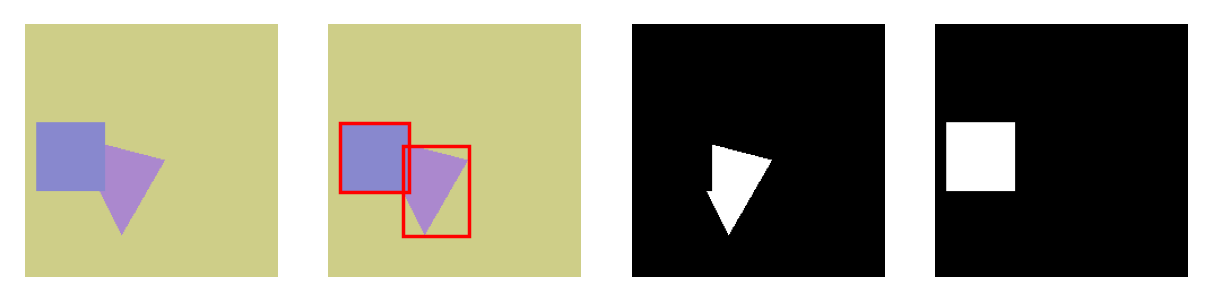

In [33]:
make_full_image_analysis(image_as_array, image_instance)